<a href="https://colab.research.google.com/github/BIGMOUSSA/image_classification_from_intel_image/blob/main/Intel_image_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install tensorflow

# PROJET USE CASE DATA DE BOUT EN BOUT

## THEME : IMAGE CLASSIFICATION : image to text -conversion and extraction - 
Ce projet consiste à utiliser les données fourni par intel dans kaggle pour faire de la classification d'image. Le dataset est composé d'au moins 25 000 images de taille 150 x 150 réparties en 6 catégories :    
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }
Les données d'entrainement, de Teste et de  Prédiction sont séparées dans des 3 dossiers zippés. Il y'a environ 14k images pour l'entrainement, 3 000 pour le teste  et  7 000  Pour la prédiction.

Notre  objectif général : Chercher le meilleur modèle pour prédire avec moins d'erreur possible si une image est un  :  {'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

Pour cela nous allons d'abord explorer les modèles classique de machine learning avant d'explorer des modèles plus puissants de deep learning. Ainsi le meilleur modèle, celui qui aura le métric le plus élevés,  sera retenu pour l'implémentation de la solution.

In [ ]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array 
from tensorflow.keras.preprocessing import image
# import ImageDataGenerator, img_to_array 

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.utils import img_to_array



## PREPARATION DES DONNEES

In [ ]:
# Définition de:
#INPUT_SHAPE = (150,150,3) 
#BATCH_SIZE = 60
test_path='data/seg_test/seg_test/'
train_path='data/seg_train/seg_train'



In [ ]:
# Tester si nos dossiers sont bien présent 
directory=os.listdir(test_path)
directory

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### Chargement de quelques images pour la visualisation

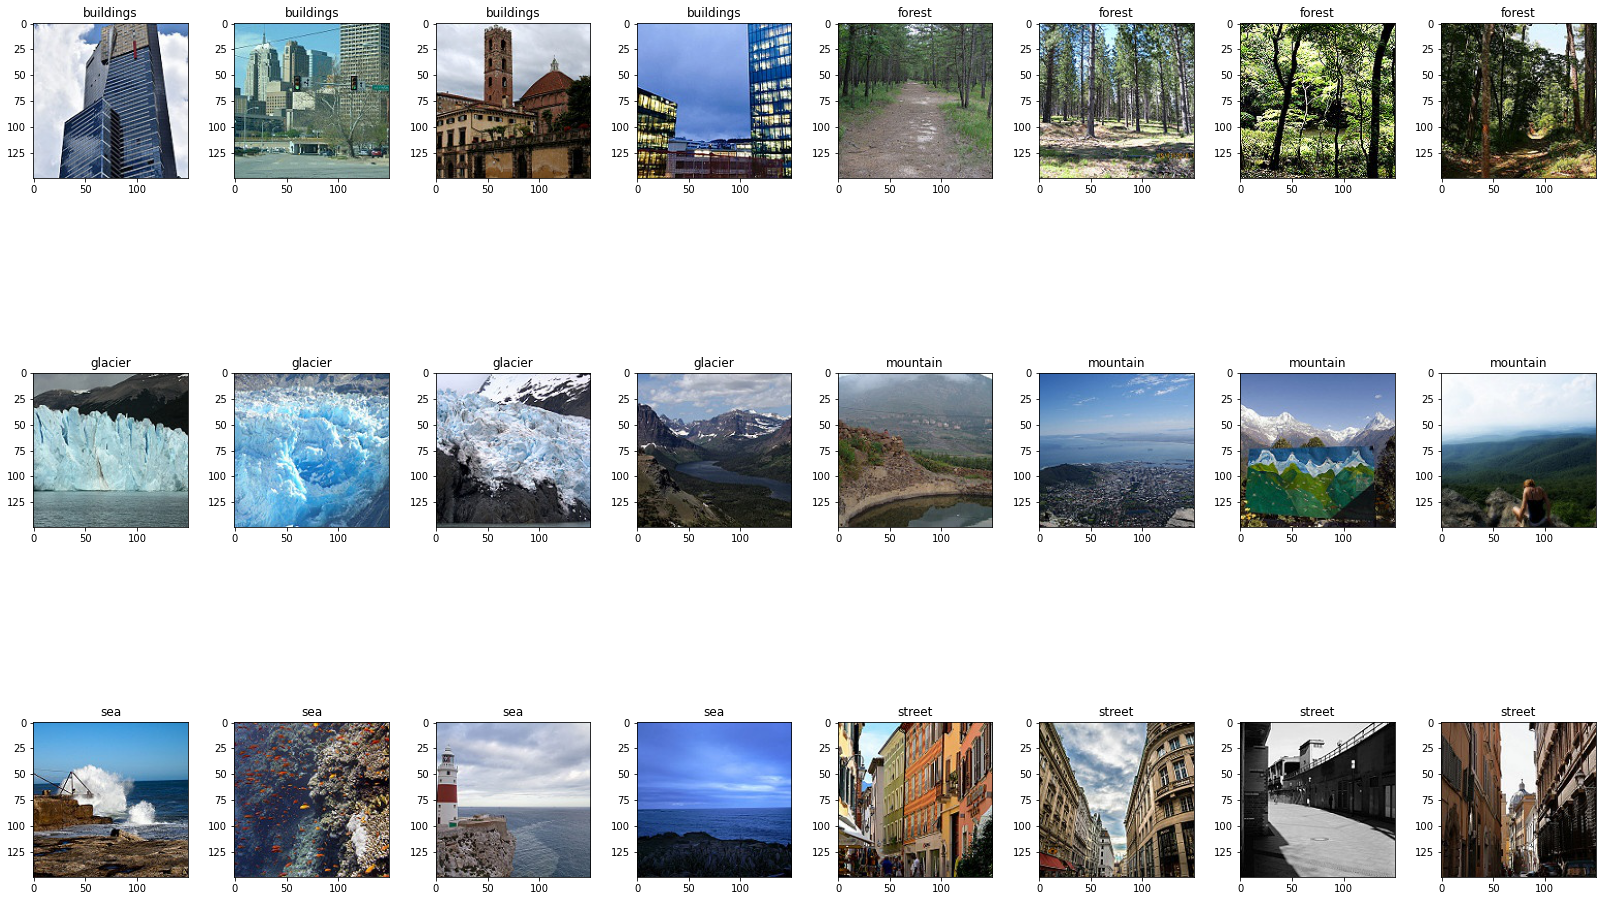

In [ ]:
def visualize_data(folder):
    c=1
    directory=os.listdir(folder)
    plt.figure(figsize=(28,20))
    for each in directory:
        currentFolder=folder+ "/" +each
        for i, file in enumerate(os.listdir(currentFolder)[0:4]):
            full_path=currentFolder+"/"+file
            plt.subplot(3, 8, c)
            img = mpimg.imread(full_path)
            plt.imshow(img)
            plt.title(each)
            c+=1
    plt.subplots_adjust(wspace=0.3, hspace=-0.1)
    plt.show()
    
visualize_data(test_path)
#/content/seg_test/seg_test/glacier

### Récuperation de toutes les images et transformation en np.array qui seront stockées dans une liste. De même que les labels qui seront enrigistrés dans une liste "lab"

In [ ]:
def makelab(folder):
    directory=os.listdir(folder)
    label=[]
    img_array=[]
    for each in directory:
        currentFolder=folder+ "/" +each
        for i, file in enumerate(os.listdir(currentFolder)):
            full_path=currentFolder+"/"+file
            img = mpimg.imread(full_path)
            if tf.keras.utils.img_to_array(img).shape==(150,150,3):
              label.append(each)
              img_array.append(tf.keras.utils.img_to_array(img))
              
    return label,img_array

In [ ]:
lab, im = makelab(train_path)


KeyboardInterrupt



Error in callback <function flush_figures at 0x000001E6DBDCA1F0> (for post_execute):



KeyboardInterrupt



In [ ]:
im[0].shape

(150, 150, 3)

In [ ]:
labels=np.unique(lab)

In [ ]:
print('number of samples: ', len(lab))
print('image shape: ', im[0].shape)
print('labels:', np.unique(lab))

number of samples:  2993
image shape:  (150, 150, 3)
labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [ ]:
X = np.array(im)
y = np.array(lab)

In [ ]:
X.shape

(2993, 150, 150, 3)

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

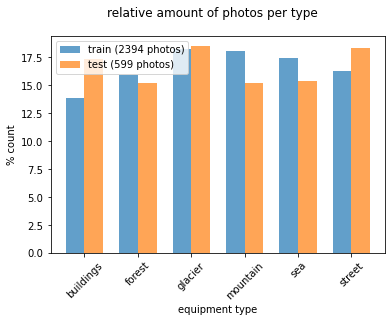

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('NATURE TYPE')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

## PROCESSING FEATURE ENGINEERING

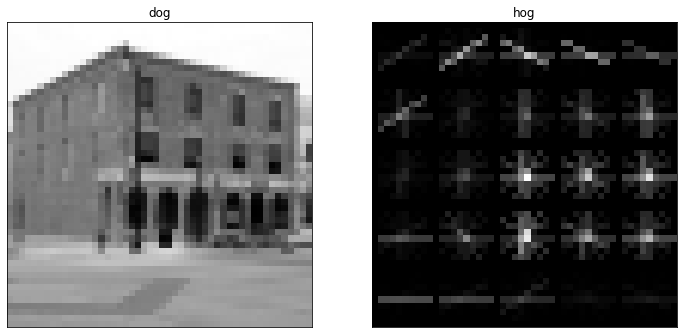

In [ ]:
### 
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
build = imread('data/seg_train/seg_train/buildings/1012.jpg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
build = rescale(build, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
build_hog, build_hog_img = hog(
    build, pixels_per_cell=(10,10), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,10)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(build, cmap='gray')
ax[0].set_title('BUILDIND')
ax[1].imshow(build_hog_img, cmap='gray')
ax[1].set_title('BUILDING hog')
plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage import color
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(12, 12),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage

 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(10, 10), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
#X_train_gray = grayify.fit_transform(X_train)
#X_train_hog = hogify.fit_transform(X_train_gray)
#X_train_prepared = scalify.fit_transform(X_train_hog)
 
#print(X_train_prepared.shape)

(2394, 7056)


In [ ]:
"""
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)
"""

SGDClassifier(random_state=42)

In [ ]:
"""
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)
"""

In [ ]:
"""
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
"""
#Percentage correct:  65.6093489148581

[ True False  True  True False False False  True  True False  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True]

Percentage correct:  65.6093489148581


In [ ]:
## GRIDSEARCH
from sklearn.model_selection import GridSearchCV

sgdc = SGDClassifier()

sgdc_params = {
    'loss':['log'],
    'penalty':['elasticnet'],
    'n_iter_no_change':[5],
    'alpha':np.logspace(-4, 0, 10),
    'l1_ratio':[0.13,0.14,0.15,0.2],
    'max_iter':[1000], 
    'tol':[1e-3]
}

#sgdc_gs = GridSearchCV(sgdc, sgdc_params, cv=5, verbose=20, n_jobs=1)

In [ ]:
#np.logspace(-4, 4, 10)

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [ ]:
#sgdc.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
#Here I fit the model to my dataset
#sgdc_gs.fit(X_train_prepared, y_train)

#Best parameters from the above gridsearch


In [ ]:
# best model 
""" SGDClassifier(alpha=0.046415888336127774, l1_ratio=0.13, loss='log',
              penalty='elasticnet')
              
"""
#sgdc_gs.best_estimator_
#SGDClassifier(alpha=0.046415888336127774, l1_ratio=0.13, loss='log',penalty='elasticnet')

SGDClassifier(alpha=0.046415888336127774, l1_ratio=0.13, loss='log',
              penalty='elasticnet')

In [ ]:
# parametres du best model
#sgdc_gs.best_params_
"""
{'alpha': 0.046415888336127774,
 'l1_ratio': 0.13,
 'loss': 'log',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'elasticnet',
 'tol': 0.001}
 """

{'alpha': 0.046415888336127774,
 'l1_ratio': 0.13,
 'loss': 'log',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'elasticnet',
 'tol': 0.001}

In [ ]:
# best score
#sgdc_gs.best_score_
#0.6566434604868931

0.6566434604868931

### confusion matrix

In [ ]:
import pandas as pd

In [ ]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))
#Percentage correct:  65.6093489148581

Percentage correct:  65.6093489148581


In [ ]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))
#Percentage correct:  74.12353923205342

Percentage correct:  74.12353923205342


## OPTIMISATION

In [ ]:
# GRID SEARCH AVEC SVC
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
#SVC_gs = GridSearchCV(SVC(), param_grid, cv=5, verbose=20, n_jobs=1)
#SVC_gs.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START C=1, gamma=1, kernel=linear................................
[CV 1/5; 1/32] END .C=1, gamma=1, kernel=linear;, score=0.651 total time=  27.5s
[CV 2/5; 1/32] START C=1, gamma=1, kernel=linear................................
[CV 2/5; 1/32] END .C=1, gamma=1, kernel=linear;, score=0.653 total time=  21.9s
[CV 3/5; 1/32] START C=1, gamma=1, kernel=linear................................
[CV 3/5; 1/32] END .C=1, gamma=1, kernel=linear;, score=0.649 total time=  25.3s
[CV 4/5; 1/32] START C=1, gamma=1, kernel=linear................................
[CV 4/5; 1/32] END .C=1, gamma=1, kernel=linear;, score=0.641 total time=  22.7s
[CV 5/5; 1/32] START C=1, gamma=1, kernel=linear................................
[CV 5/5; 1/32] END .C=1, gamma=1, kernel=linear;, score=0.651 total time=  22.6s
[CV 1/5; 2/32] START C=1, gamma=1, kernel=rbf...................................


In [ ]:
#HOG_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'grayify', 'hogify', 'scalify', 'classify', 'hogify__block_norm', 'hogify__cells_per_block', 'hogify__orientations', 'hogify__pixels_per_cell', 'hogify__y', 'scalify__copy', 'scalify__with_mean', 'scalify__with_std', 'classify__C', 'classify__break_ties', 'classify__cache_size', 'classify__class_weight', 'classify__coef0', 'classify__decision_function_shape', 'classify__degree', 'classify__gamma', 'classify__kernel', 'classify__max_iter', 'classify__probability', 'classify__random_state', 'classify__shrinking', 'classify__tol', 'classify__verbose'])

In [ ]:
#grid = GridSearchCV(HOG_pipeline ,param_grid,refit = True, verbose=10)

In [ ]:
#grid.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START classify__C=1, classify__gamma=1, classify__kernel=linear..
[CV 1/5; 1/32] END classify__C=1, classify__gamma=1, classify__kernel=linear;, score=0.653 total time= 1.4min
[CV 2/5; 1/32] START classify__C=1, classify__gamma=1, classify__kernel=linear..
[CV 2/5; 1/32] END classify__C=1, classify__gamma=1, classify__kernel=linear;, score=0.653 total time= 1.2min
[CV 3/5; 1/32] START classify__C=1, classify__gamma=1, classify__kernel=linear..
[CV 3/5; 1/32] END classify__C=1, classify__gamma=1, classify__kernel=linear;, score=0.649 total time= 1.0min
[CV 4/5; 1/32] START classify__C=1, classify__gamma=1, classify__kernel=linear..



KeyboardInterrupt



In [ ]:
# svc kernel =  "rbf"
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC())
])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))
#Percentage correct:  73.03621169916434

In [ ]:
# svc kernel =  "rbf"
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8), 
        cells_per_block=(3, 3), 
        orientations=8, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC())
])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))
#Percentage correct:  71.42061281337047

In [ ]:
# svc linear
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8), 
        cells_per_block=(3, 3), 
        orientations=8, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(kernel="linear"))
  ])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))
# Percentage correct:  66.74094707520891

In [ ]:
# svc linear
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(kernel="linear"))
  ])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))
#Percentage correct:  66.46239554317549

In [ ]:
from sklearn.model_selection import GridSearchCV
 
param_grid_sgd = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(alpha=0.046415888336127774, l1_ratio=0.13, loss='log',
              penalty='elasticnet',random_state=42, max_iter=1000, tol=1e-3)
         ]
    }
]

In [ ]:
#sklearn.ensemble.AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)[source]¶
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier,RandomForestClassifier


In [ ]:
#Bagging
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', BaggingClassifier())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  48.080133555926544


In [ ]:
#Gradient
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', GradientBoostingClassifier())
])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))
#Percentage correct:  67.89297658862876

Percentage correct:  68.2804674457429


In [ ]:
#HistGrad
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', HistGradientBoostingClassifier())
])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

In [ ]:
#Random
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', RandomForestClassifier())
])
 
#clf = HOG_pipeline.fit(X_train, y_train)
#print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

In [ ]:
# save the model to disk
import joblib
#joblib.dump(grid_res, 'hog_sgd_model.pkl');

In [ ]:
# description of the best performing object, a pipeline in our case.
#grid_res.best_estimator_

In [ ]:
# the highscore during the search
#grid_res.best_score_

## APPROCHE DEEP LEARNING CNN

In [ ]:
INPUT_SHAPE = (150,150,3) 
BATCH_SIZE = 60

In [ ]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
def get_generator(_training_dir, _test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1/255.0, 
        featurewise_center=True,
        featurewise_std_normalization=True, 
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        shear_range=0.2,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(
        rescale=1/255.0
    )
    train_generator = train_datagen.flow_from_directory(
        _training_dir,
        shuffle=True,
        target_size=(150,150),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        _test_dir,
        shuffle=True,
        target_size=(150,150),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    return train_generator, test_generator

In [ ]:
train_generator, test_generator = get_generator(train_path, test_path)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
train_generator.labels

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [ ]:
train_generator

In [ ]:
def get_initialized_model(INPUT_SHAPE):
    base_model = InceptionResNetV2(
        input_shape=INPUT_SHAPE,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    base_model.trainable = False
    
    print('Base Model Ouput Shape = {}'.format(base_model.output_shape))
    last_output = base_model.output
    x = tf.keras.layers.Dropout(0.2)(last_output)
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units = 6, activation='softmax')(x)
    
    model = tf.keras.Model( base_model.input, x) 

    model.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.9, centered=True), 
        loss = ['categorical_crossentropy'], 
        metrics = ['accuracy']
    )

    model_callback = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0.001, 
        patience=5, 
        verbose=1,
        mode='auto', 
        baseline=None, 
        restore_best_weights=True
    ), tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=1,
        min_delta=0.0000001,
        verbose=1 
    )]
    
    return model, model_callback

In [ ]:
model, model_callbacks = get_initialized_model(INPUT_SHAPE)

219070464/219055592 [==============================] - 2s 0us/step
Base Model Ouput Shape = (None, 1536)


In [ ]:
history = model.fit_generator(train_generator, epochs=30, validation_data=test_generator, callbacks=[model_callbacks])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
234/234 [==============================] - 1458s 6s/step - loss: 0.7132 - accuracy: 0.7380 - val_loss: 0.3285 - val_accuracy: 0.8790 - lr: 1.0000e-04
Epoch 2/30
234/234 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.8065
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
234/234 [==============================] - 1403s 6s/step - loss: 0.5262 - accuracy: 0.8065 - val_loss: 0.3352 - val_accuracy: 0.8637 - lr: 1.0000e-04
Epoch 3/30
 14/234 [>.............................] - ETA: 18:34 - loss: 0.5751 - accuracy: 0.8095

KeyboardInterrupt: ignored

In [ ]:
def plotter(history):
    #summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
score = model.evaluate_generator(test_generator)
plotter(history)
print('\nScore [ {} ] '.format(dict(zip(model.metrics_names, score))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


NameError: ignored

# OPTIMISATION DU MODELE

* Les couches rendus non entraînables auparavant sont maintenant modifiés. Cette modification est limitée aux 100 dernières couches, qui sont rendues ****Trainable**.**. De plus, les couches rendues trainable sont également énumérées spécifiquement et affichées (sélectionnez pour afficher la sortie)

In [ ]:
for layer in model.layers[-100:]:
    layer.trainable=True

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

* Recompilation avec l'optimiseur ** Adam ** sur un taux d'apprentissage relativement faible de 0,00001, et ajustement des rappels.

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss = ['categorical_crossentropy'], 
    metrics = ['accuracy']
)    

model_callback_new = [tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=3, 
    verbose=1,
    mode='auto', 
    baseline=None, 
    restore_best_weights=True
), tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_delta=0.00000001,
    verbose=1 
)]

In [ ]:
#resetting the generators
train_generator.reset()
test_generator.reset()

history = model.fit_generator(
    train_generator,
    epochs=25,
    steps_per_epoch=14034//BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=3000//BATCH_SIZE,
    callbacks=[model_callback_new]
)

* Réévaluer le score et tracer les précisions et les pertes.

In [ ]:
score = model.evaluate_generator(test_generator)
plotter(history)
print('\nScore [ {} ] '.format(dict(zip(model.metrics_names, score))))

## DEPLOIEMENT DU MODELE

In [ ]:
model.save('model.h5')

### DEPLOIEMENT AVEC GRADIO

In [ ]:
#!pip install gradio

In [ ]:
class_names=list(train_generator.class_indices.keys())
class_names

In [ ]:
from keras.models import load_model
model = load_model('model.h5')
model.make_predict_function()
def predict_image(img):
  img_4d=img.reshape(1,150,150,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]:float(prediction[i]) for i in range(6)}

In [ ]:
import gradio as gr
image = gr.inputs.Image(shape=(150,150))
label = gr.outputs.Label(num_top_classes=6)
gr.Interface(fn=predict_image,inputs=image,outputs=label,interpretation='default').launch(debug=True)